In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('mock_kaggle.csv')

In [ ]:
df

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


In [ ]:
df=df.rename(columns={'data':'date','venda':'Sales','estoque':'Stock','preco':'Price'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    937 non-null    object 
 1   Sales   937 non-null    int64  
 2   Stock   937 non-null    int64  
 3   Price   937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB


In [ ]:
df.describe()

,Sales,Stock,Price
count,937.000000,937.000000,937.000000
mean,90.533618,1608.258271,1.592572
std,80.682089,1356.691877,0.529502
min,0.000000,0.000000,0.000000
25%,33.000000,794.000000,1.290000
50%,76.000000,1348.000000,1.390000
75%,127.000000,1964.000000,1.890000
max,542.000000,7228.000000,2.980000


**1.Data Preprocessing**

In [ ]:
df.isnull().sum()

,0
date,0
Sales,0
Stock,0
Price,0


In [ ]:
df.isna().sum()

,0
date,0
Sales,0
Stock,0
Price,0


In [ ]:
duplicates=df.duplicated().sum()
print(duplicates)

0


In [ ]:
df=df.rename(columns={'date':'ds','Sales':'y'}) # for prophet

In [ ]:
df['ds']=pd.to_datetime(df['ds'])

In [ ]:
df

,ds,y,Stock,Price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


In [ ]:
df_monthly=df.resample('ME',on='ds').sum().reset_index() # monthly totals

In [ ]:
df_monthly['month']=df_monthly['ds'].dt.month # seasonal changes
df_monthly['year']=df_monthly['ds'].dt.year

In [ ]:
df_monthly['is_festive']=df_monthly['month'].isin([10,11,12]).astype(int) # festive spikes

**2.EDA**

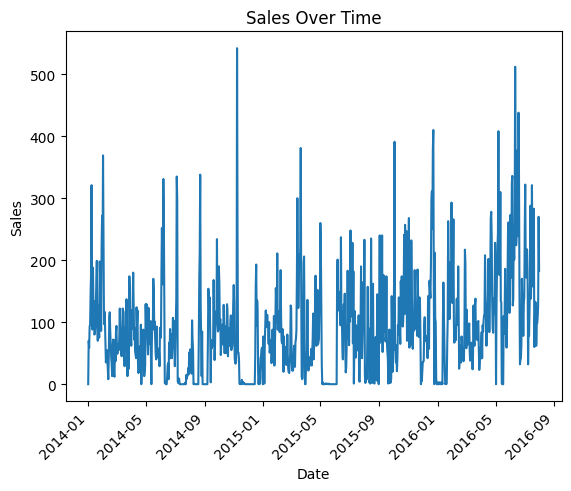

In [ ]:
plt.figure()
plt.plot(df['ds'],df['y'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.xticks(rotation=45, ha='right')
plt.show()

Text(0.5, 1.0, 'Average Sales by Month')

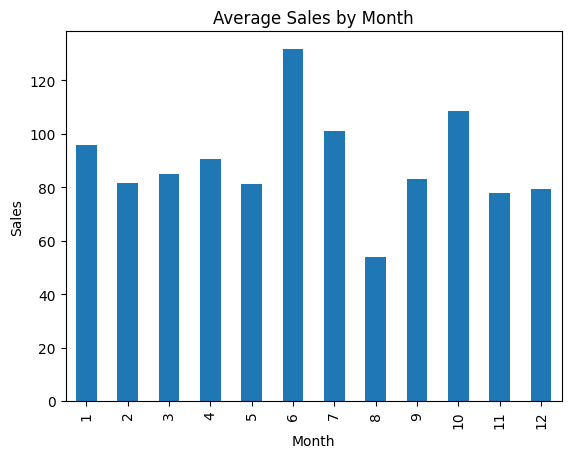

In [ ]:
df['month']=df['ds'].dt.month
df.groupby('month')['y'].mean().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Average Sales by Month')

Text(0.5, 1.0, 'Average Sales by Year')

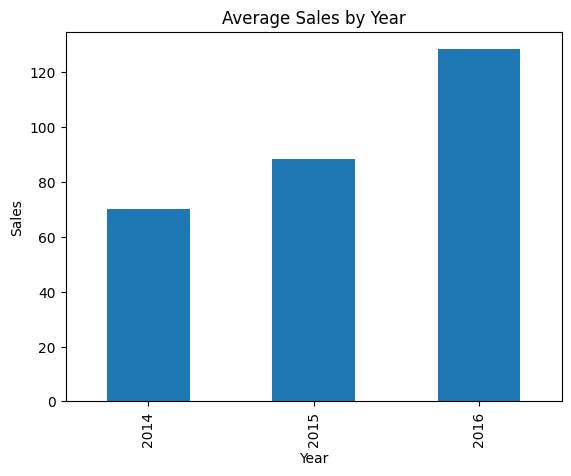

In [ ]:
df['year']=df['ds'].dt.year
df.groupby('year')['y'].mean().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Average Sales by Year')

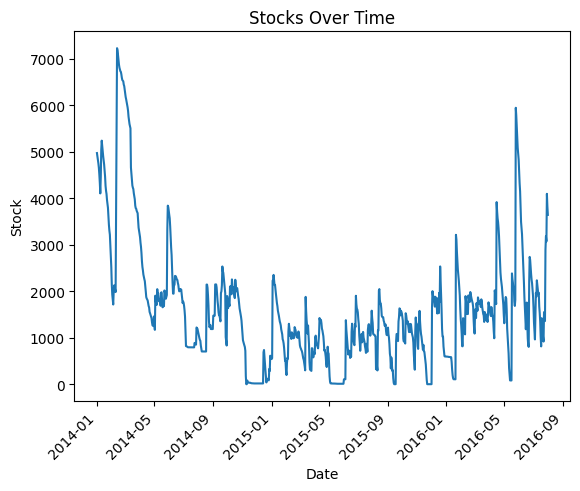

In [ ]:
plt.figure()
plt.plot(df['ds'],df['Stock'])
plt.xlabel('Date')
plt.ylabel('Stock')
plt.title('Stocks Over Time')
plt.xticks(rotation=45, ha='right')
plt.show()

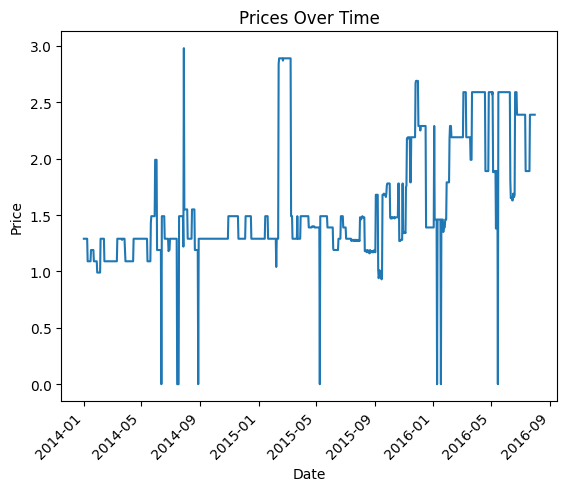

In [ ]:
plt.figure()
plt.plot(df['ds'],df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Prices Over Time')
plt.xticks(rotation=45, ha='right')
plt.show()

Text(0.5, 1.0, 'Average Stocks by Month')

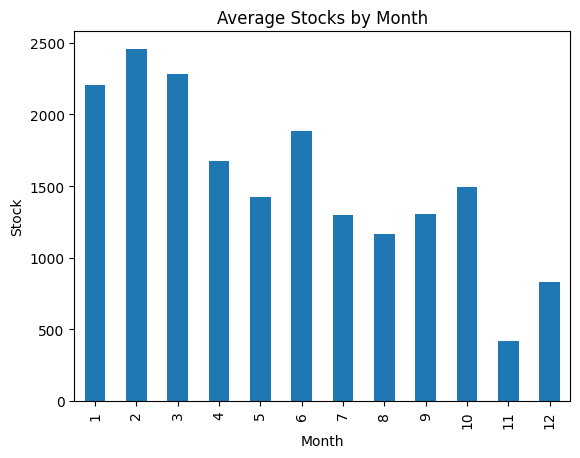

In [ ]:
df['month']=df['ds'].dt.month
df.groupby('month')['Stock'].mean().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Stock')
plt.title('Average Stocks by Month')

Text(0.5, 1.0, 'Average Price by Year')

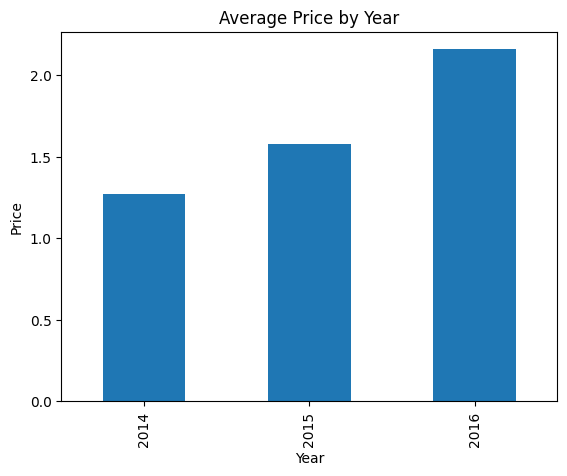

In [ ]:
df['year']=df['ds'].dt.year
df.groupby('year')['Price'].mean().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Average Price by Year')

Text(0.5, 1.0, 'Average Sales by Year')

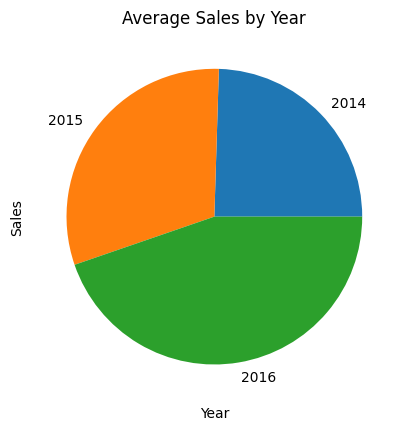

In [ ]:
df['year']=df['ds'].dt.year
df.groupby('year')['y'].mean().plot(kind='pie')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Average Sales by Year')

In [ ]:
df=df[['ds','y']]

In [ ]:
df

,ds,y
0,2014-01-01,0
1,2014-01-02,70
2,2014-01-03,59
3,2014-01-04,93
4,2014-01-05,96
...,...,...
932,2016-07-27,98
933,2016-07-28,108
934,2016-07-29,128
935,2016-07-30,270


**3.Time-Series Forecasting**

In [ ]:
from prophet import Prophet
model=Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
model.fit(df_monthly[['ds','y']])

INFO:prophet:n_changepoints greater than number of observations. Using 23.


In [ ]:
future=model.make_future_dataframe(periods=12,freq='ME')
forecast=model.predict(future)

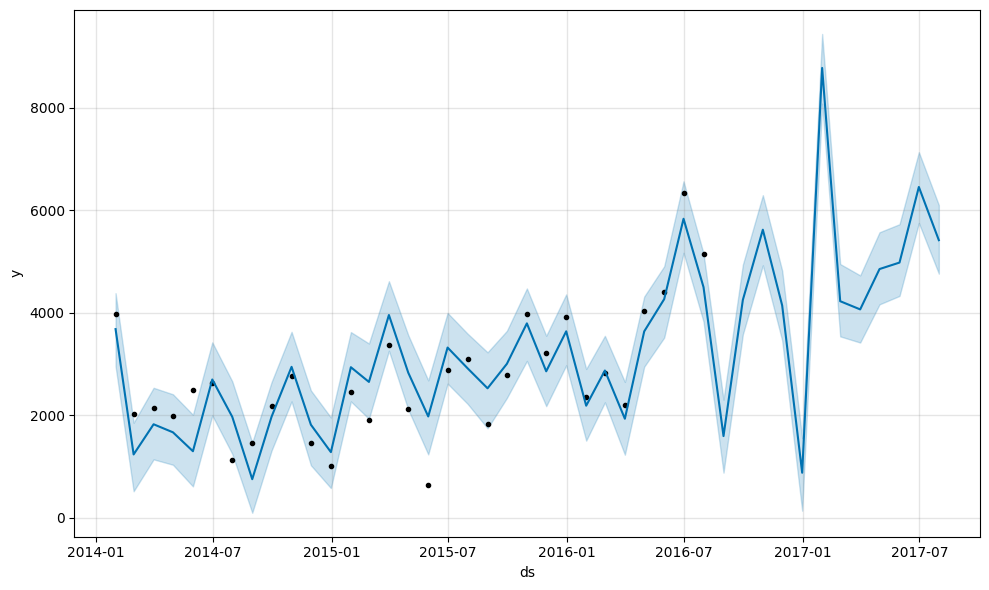

In [ ]:
model.plot(forecast)
plt.show()

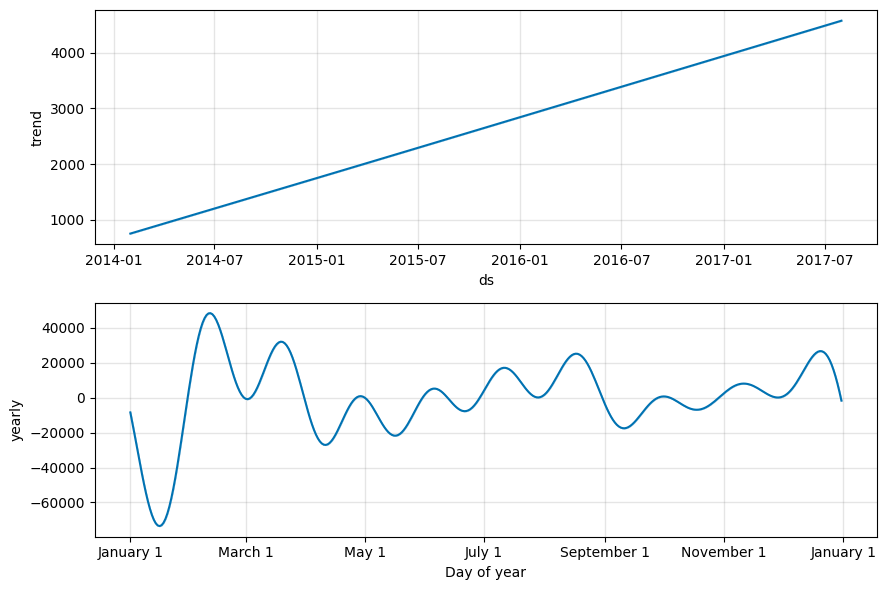

In [ ]:
model.plot_components(forecast)
plt.show()

**4.Model Forecasting**

In [ ]:
from sklearn.metrics import mean_absolute_error
actual=df_monthly['y']
predicted=forecast['yhat'][:len(actual)]
mae=mean_absolute_error(actual,predicted)
print(mae)

448.47998596389056


**5.Exporting the data**

In [ ]:
final_df=forecast[['ds','yhat','yhat_lower','yhat_upper']]
final_df.to_csv('Sales_Forecast.csv',index=False)